In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = '/content/drive/My Drive/Sales Forecast/store-sales-time-series-forecasting/'

test_data_path = f'{folder_path}test.csv'
train_data_path = f'{folder_path}train.csv'
stores_data_path = f'{folder_path}stores.csv'
oil_data_path = f'{folder_path}oil.csv'
holidays_data_path = f'{folder_path}holidays_events.csv'


In [ ]:
# Reading data 2000 rows just to test code
train_df = pd.read_csv(train_data_path,nrows=700000)
#test_df = pd.read_csv(test_data_path)
oil_df = pd.read_csv(oil_data_path)
stores_df = pd.read_csv(stores_data_path)
holidays_df = pd.read_csv(holidays_data_path)


In [ ]:
#removing all dates from holidays on which holiday is transferred
holidays_df = holidays_df[~holidays_df['transferred']]

#after filtering the transfered days , trnsfered column is unnecessay so we have to drop it
holidays_df = holidays_df.drop(columns=['transferred'])

#All of the filtered days have holiday
holidays_df['is_holiday'] = True

#Rename type column to holiday_type

holidays_df.rename(columns={'type': 'holiday_type'}, inplace=True)



In [ ]:
#fill the missing values in oil data frame with bfill forward method

mean_value = oil_df['dcoilwtico'].mean()
oil_df['dcoilwtico'].fillna(mean_value, inplace=True)

#print(oil_df['dcoilwtico'].isnull().sum())

In [ ]:
#id is unnecessary , we can remove it

train_df =train_df.drop(columns=['id'])


In [ ]:
#Merging dataframes

data_set = train_df.merge(holidays_df, on='date', how='left')

data_set = data_set.merge(oil_df, on='date', how='left')

data_set = data_set.merge(stores_df, on='store_nbr', how='left')

#handling missing and NaN values

data_set = data_set.fillna({
    'is_holiday': False,
    'locale': '',
    'locale_name': '',
    'description': '',
    'holiday_type' : '',
    'holiday_name': ''
})




In [ ]:
# Data Preprocessing Block

#Extracting additional featuress from Date

data_set['date'] = pd.to_datetime(data_set['date'])
data_set['day'] = data_set['date'].dt.day
data_set['day_of_week'] = data_set['date'].dt.day_of_week
data_set['month'] = data_set['date'].dt.month
data_set['year'] = data_set['date'].dt.year
data_set['is_weekend'] = data_set['day_of_week']>=5

#dropped the date column to remove redundency
#data_set.drop(columns=['date'], inplace=True)

#preprocessing binary columns
binary_colunms = ['is_holiday', 'is_weekend']
data_set[binary_colunms] = data_set[binary_colunms].astype(int)


In [ ]:
# Sort the DataFrame by date if not already sorted
data_set = data_set.sort_values(by='date')

# Calculate the index for the 80% split
split_index = int(len(data_set) * 0.8)

# Split the data into training and testing sets
train_data = data_set.iloc[:split_index]
test_data = data_set.iloc[split_index:]

# Display the first few rows of the training set
train_data.head()



,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,is_holiday,dcoilwtico,city,state,type,cluster,day,day_of_week,month,year,is_weekend
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,1,67.714366,Quito,Pichincha,D,13,1,1,1,2013,0
1194,2013-01-01,42,CELEBRATION,0.0,0,Holiday,National,Ecuador,Primer dia del ano,1,67.714366,Cuenca,Azuay,D,2,1,1,1,2013,0
1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,1,67.714366,Cuenca,Azuay,D,2,1,1,1,2013,0
1192,2013-01-01,42,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,1,67.714366,Cuenca,Azuay,D,2,1,1,1,2013,0
1191,2013-01-01,42,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,1,67.714366,Cuenca,Azuay,D,2,1,1,1,2013,0


In [ ]:
import tensorflow as tf
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set GPU memory growth to avoid allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Num GPUs Available:  1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# Apply backward fill to 'dcoilwtico' column
data_set['dcoilwtico'] = data_set['dcoilwtico'].bfill()

# Check for remaining missing values
print(data_set.isnull().sum())

# Define sequence length and columns
sequence_length = 10
categorical_columns = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster', 'locale', 'locale_name', 'description', 'holiday_type', 'day_of_week', 'month', 'day']
non_categorical_columns = ['year', 'is_holiday', 'onpromotion', 'dcoilwtico']
target_column = 'sales'

# Define batch size
batch_size = 32

# Function to create sequences as generator
def create_sequences_generator(data, categorical_columns, non_categorical_columns, target_column, sequence_length, batch_size=32):
    num_samples = len(data) - sequence_length
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]

            X_cat_batch = []
            X_non_cat_batch = []
            y_batch = []

            for i in batch_indices:
                X_cat_seq = [data[col].values[i:i + sequence_length] for col in categorical_columns]
                X_non_cat_seq = data[non_categorical_columns].values[i:i + sequence_length]
                y_seq = data[target_column].values[i + sequence_length]

                X_cat_batch.append(np.array(X_cat_seq).T)
                X_non_cat_batch.append(X_non_cat_seq)
                y_batch.append(y_seq)

            # Convert lists to arrays
            X_cat_batch = np.array(X_cat_batch)
            X_non_cat_batch = np.array(X_non_cat_batch)
            y_batch = np.array(y_batch)

            # Yield the batch as a tuple of inputs and outputs
            yield (
                tuple(tf.convert_to_tensor(X_cat_batch[:, :, j], dtype=tf.int32) for j in range(len(categorical_columns))) + (tf.convert_to_tensor(X_non_cat_batch, dtype=tf.float32),),
                tf.convert_to_tensor(y_batch, dtype=tf.float32)
            )

# Load your data
# data_set = pd.read_csv('your_data.csv')  # Replace with your data file

# Split data into training and test sets
split_ratio = 0.8
split_index = int(len(data_set) * split_ratio)
train_data = data_set[:split_index]
test_data = data_set[split_index:]

# Convert categorical columns to numerical codes
for col in categorical_columns:
    train_data[col] = train_data[col].astype('category').cat.codes
    test_data[col] = pd.Categorical(test_data[col], categories=train_data[col].astype('category').cat.categories).codes

# Standardize non-categorical columns
scaler = StandardScaler()
train_data[non_categorical_columns] = scaler.fit_transform(train_data[non_categorical_columns])
test_data[non_categorical_columns] = scaler.transform(test_data[non_categorical_columns])

# Create TensorFlow dataset generators
def create_tf_dataset(data, categorical_columns, non_categorical_columns, target_column, sequence_length, batch_size):
    return tf.data.Dataset.from_generator(
        lambda: create_sequences_generator(data, categorical_columns, non_categorical_columns, target_column, sequence_length, batch_size),
        output_signature=(
            (
                tuple(tf.TensorSpec(shape=(None, sequence_length), dtype=tf.int32) for _ in categorical_columns) +
                (tf.TensorSpec(shape=(None, sequence_length, len(non_categorical_columns)), dtype=tf.float32),)
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )

train_gen = create_tf_dataset(train_data, categorical_columns, non_categorical_columns, target_column, sequence_length, batch_size)
val_gen = create_tf_dataset(test_data, categorical_columns, non_categorical_columns, target_column, sequence_length, batch_size)

# Define the LSTM model with embeddings
inputs = []
embeddings = []

for i, col in enumerate(categorical_columns):
    input_layer = Input(shape=(sequence_length,))
    embedding_size = min(50, len(train_data[col].unique()) // 2)
    embedding_layer = Embedding(input_dim=len(train_data[col].unique()), output_dim=embedding_size)(input_layer)
    embeddings.append(embedding_layer)
    inputs.append(input_layer)

# Non-categorical input
non_cat_input = Input(shape=(sequence_length, len(non_categorical_columns)))
inputs.append(non_cat_input)

# Concatenate embeddings and non-categorical inputs
lstm_input = Concatenate(axis=-1)(embeddings + [non_cat_input])

# LSTM layers with Dropout and Bidirectional LSTM
lstm_out = Bidirectional(LSTM(100, return_sequences=True))(lstm_input)
lstm_out = LSTM(50, return_sequences=False)(lstm_out)
lstm_out = Dropout(0.3)(lstm_out)

# Output layer
output = Dense(1)(lstm_out)

# Build and compile the model
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=optimizer, loss='mse')

# Model summary
model.summary()

# Define callbacks for learning rate reduction and model checkpoint
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/My Drive/store_sale_forecast_model/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
model.fit(
    train_gen,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=len(test_data) // batch_size,
    callbacks=[lr_scheduler, checkpoint]
)

# Evaluate the model on the test set
test_loss = model.evaluate(val_gen, steps=len(test_data) // batch_size)
print(f'Test Loss: {test_loss}')

# Save the final model to Google Drive in .keras format
model_save_path = '/content/drive/My Drive/store_sale_forecast_model/lstm_final.keras'  # Change the path as needed
model.save(model_save_path)
print(f"Model saved to {model_save_path}")



date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
is_holiday      0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
day             0
day_of_week     0
month           0
year            0
is_weekend      0
dtype: int64


<ipython-input-13-d59d3f5d2025>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[col] = train_data[col].astype('category').cat.codes
<ipython-input-13-d59d3f5d2025>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[col] = pd.Categorical(test_data[col], categories=train_data[col].astype('category').cat.categories).codes
<ipython-input-13-d59d3f5d2025>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_16            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_18            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_19            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_20            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_21            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_22            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_23            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_24            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_25            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 214,869 (839.33 KB)

 Trainable params: 214,869 (839.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 817s 161ms/step - loss: 484570.3750 - val_loss: 551589.6250 - learning_rate: 1.0000e-04
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 810s 162ms/step - loss: 457261.0938 - val_loss: 551389.7500 - learning_rate: 1.0000e-04
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 813s 163ms/step - loss: 434449.6250 - val_loss: 551965.1250 - learning_rate: 1.0000e-04
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 816s 163ms/step - loss: 446454.5625 - val_loss: 551575.6250 - learning_rate: 1.0000e-04
Epoch 5/50
2700/5000 ━━━━━━━━━━━━━━━━━━━━ 5:31 144ms/step - loss: 444105.0312

KeyboardInterrupt: 

used one hot encoding inseated of embedding

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# Apply backward fill to 'dcoilwtico' column
data_set['dcoilwtico'] = data_set['dcoilwtico'].bfill()

# Check for remaining missing values
print(data_set.isnull().sum())

# Define sequence length and columns
sequence_length = 10
categorical_columns = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster', 'locale', 'locale_name', 'description', 'holiday_type', 'day_of_week', 'month', 'day']
non_categorical_columns = ['year', 'is_holiday', 'onpromotion', 'dcoilwtico']
target_column = 'sales'

# Define batch size
batch_size = 32

# Split data into training and test sets
split_ratio = 0.8
split_index = int(len(data_set) * split_ratio)
train_data = data_set[:split_index]
test_data = data_set[split_index:]

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_train_cats = encoder.fit_transform(train_data[categorical_columns])
encoded_test_cats = encoder.transform(test_data[categorical_columns])

# Standardize non-categorical columns
scaler = StandardScaler()
scaled_train_non_cats = scaler.fit_transform(train_data[non_categorical_columns])
scaled_test_non_cats = scaler.transform(test_data[non_categorical_columns])

# Function to create sequences
def create_sequences(data_cat, data_non_cat, target, sequence_length, batch_size):
    num_samples = len(target) - sequence_length
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]

            X_cat_batch = []
            X_non_cat_batch = []
            y_batch = []

            for i in batch_indices:
                X_cat_seq = data_cat[i:i + sequence_length]  # Extract the sequence of one-hot encoded categorical data
                X_non_cat_seq = data_non_cat[i:i + sequence_length]  # Extract the sequence of non-categorical data
                y_seq = target[i + sequence_length]  # Target value for prediction

                X_cat_batch.append(X_cat_seq)
                X_non_cat_batch.append(X_non_cat_seq)
                y_batch.append(y_seq)

            # Convert lists to arrays
            X_cat_batch = np.array(X_cat_batch)
            X_non_cat_batch = np.array(X_non_cat_batch)
            y_batch = np.array(y_batch)

            # Yield the batch as a tuple of inputs and outputs
            yield (
                (tf.convert_to_tensor(X_cat_batch, dtype=tf.float32), tf.convert_to_tensor(X_non_cat_batch, dtype=tf.float32)),
                tf.convert_to_tensor(y_batch, dtype=tf.float32)
            )

# Create the TensorFlow dataset generators
train_gen = create_sequences(encoded_train_cats, scaled_train_non_cats, train_data[target_column].values, sequence_length, batch_size)
val_gen = create_sequences(encoded_test_cats, scaled_test_non_cats, test_data[target_column].values, sequence_length, batch_size)

# Define the LSTM model with one-hot encoded inputs
cat_input = Input(shape=(sequence_length, encoded_train_cats.shape[1]))  # Adjust input shape to match the one-hot encoded data
non_cat_input = Input(shape=(sequence_length, len(non_categorical_columns)))  # Non-categorical input

# Concatenate the inputs
lstm_input = Concatenate(axis=-1)([cat_input, non_cat_input])

# LSTM layers with Dropout and Bidirectional LSTM
lstm_out = Bidirectional(LSTM(100, return_sequences=True))(lstm_input)
lstm_out = LSTM(50, return_sequences=False)(lstm_out)
lstm_out = Dropout(0.3)(lstm_out)

# Output layer
output = Dense(1)(lstm_out)

# Build and compile the model
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model = Model(inputs=[cat_input, non_cat_input], outputs=output)
model.compile(optimizer=optimizer, loss='mse')

# Model summary
model.summary()

# Define callbacks for learning rate reduction and model checkpoint
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/My Drive/store_sale_forecast_model/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
model.fit(
    train_gen,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=len(test_data) // batch_size,
    callbacks=[lr_scheduler, checkpoint]
)

# Evaluate the model on the test set
test_loss = model.evaluate(val_gen, steps=len(test_data) // batch_size)
print(f'Test Loss: {test_loss}')

# Save the final model to Google Drive in .keras format
model_save_path = '/content/drive/My Drive/store_sale_forecast_model/lstm_final.keras'  # Change the path as needed
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
is_holiday      0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
day             0
day_of_week     0
month           0
year            0
is_weekend      0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30            │ (None, 10, 203)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_31            │ (None, 10, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 10, 207)        │              0 │ input_layer_30[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_31[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 10, 200)        │        246,400 │ concatenate_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ (None, 50)             │         50,200 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 50)             │              0 │ lstm_9[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             51 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 296,651 (1.13 MB)

 Trainable params: 296,651 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - loss: 470641.3125 - val_loss: 539367.3750 - learning_rate: 1.0000e-04
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - loss: 453881.5000 - val_loss: 529135.5625 - learning_rate: 1.0000e-04
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - loss: 451224.0938 - val_loss: 519900.5938 - learning_rate: 1.0000e-04
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - loss: 436137.2188 - val_loss: 511385.5938 - learning_rate: 1.0000e-04
Epoch 5/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - loss: 429174.7500 - val_loss: 503023.9688 - learning_rate: 1.0000e-04
Epoch 6/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 406323.8750 - val_loss: 495014.0312 - learning_rate: 1.0000e-04
Epoch 7/50
2105/5000 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 386024.9062

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# Apply backward fill to 'dcoilwtico' column
data_set['dcoilwtico'] = data_set['dcoilwtico'].bfill()

# Check for remaining missing values
print(data_set.isnull().sum())

# Define sequence length and columns
sequence_length = 10
categorical_columns = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster', 'locale', 'locale_name', 'description', 'holiday_type', 'day_of_week', 'month', 'day']
non_categorical_columns = ['year', 'is_holiday', 'onpromotion', 'dcoilwtico']
target_column = 'sales'

# Define batch size
batch_size = 32

# Split data into training and test sets
split_ratio = 0.8
split_index = int(len(data_set) * split_ratio)
train_data = data_set[:split_index]
test_data = data_set[split_index:]

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_train_cats = encoder.fit_transform(train_data[categorical_columns])
encoded_test_cats = encoder.transform(test_data[categorical_columns])

# Standardize non-categorical columns
scaler = StandardScaler()
scaled_train_non_cats = scaler.fit_transform(train_data[non_categorical_columns])
scaled_test_non_cats = scaler.transform(test_data[non_categorical_columns])

# Function to create sequences
def create_sequences(data_cat, data_non_cat, target, sequence_length, batch_size):
    num_samples = len(target) - sequence_length
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]

            X_cat_batch = []
            X_non_cat_batch = []
            y_batch = []

            for i in batch_indices:
                X_cat_seq = data_cat[i:i + sequence_length]  # Extract the sequence of one-hot encoded categorical data
                X_non_cat_seq = data_non_cat[i:i + sequence_length]  # Extract the sequence of non-categorical data
                y_seq = target[i + sequence_length]  # Target value for prediction

                X_cat_batch.append(X_cat_seq)
                X_non_cat_batch.append(X_non_cat_seq)
                y_batch.append(y_seq)

            # Convert lists to arrays
            X_cat_batch = np.array(X_cat_batch)
            X_non_cat_batch = np.array(X_non_cat_batch)
            y_batch = np.array(y_batch)

            # Yield the batch as a tuple of inputs and outputs
            yield (
                (tf.convert_to_tensor(X_cat_batch, dtype=tf.float32), tf.convert_to_tensor(X_non_cat_batch, dtype=tf.float32)),
                tf.convert_to_tensor(y_batch, dtype=tf.float32)
            )

# Create the TensorFlow dataset generators
train_gen = create_sequences(encoded_train_cats, scaled_train_non_cats, train_data[target_column].values, sequence_length, batch_size)
val_gen = create_sequences(encoded_test_cats, scaled_test_non_cats, test_data[target_column].values, sequence_length, batch_size)

# Define the LSTM model with one-hot encoded inputs
cat_input = Input(shape=(sequence_length, encoded_train_cats.shape[1]))  # Adjust input shape to match the one-hot encoded data
non_cat_input = Input(shape=(sequence_length, len(non_categorical_columns)))  # Non-categorical input

# Concatenate the inputs
lstm_input = Concatenate(axis=-1)([cat_input, non_cat_input])

# LSTM layers with Dropout and Bidirectional LSTM
lstm_out = Bidirectional(LSTM(50, return_sequences=True))(lstm_input)
lstm_out = LSTM(25, return_sequences=False)(lstm_out)
lstm_out = Dropout(0.3)(lstm_out)

# Output layer
output = Dense(1)(lstm_out)

# Build and compile the model
optimizer = Adam(learning_rate=0.00001, clipnorm=1.0)
model = Model(inputs=[cat_input, non_cat_input], outputs=output)
model.compile(optimizer=optimizer, loss='mse')

# Model summary
model.summary()

# Define callbacks for learning rate reduction and model checkpoint
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/My Drive/store_sale_forecast_model/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
model.fit(
    train_gen,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=len(test_data) // batch_size,
    callbacks=[lr_scheduler, checkpoint]
)

# Evaluate the model on the test set
test_loss = model.evaluate(val_gen, steps=len(test_data) // batch_size)
print(f'Test Loss: {test_loss}')

# Save the final model to Google Drive in .keras format
model_save_path = '/content/drive/My Drive/store_sale_forecast_model/lstm_final.keras'  # Change the path as needed
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
is_holiday      0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
day             0
day_of_week     0
month           0
year            0
is_weekend      0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 10, 203)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_33            │ (None, 10, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 10, 207)        │              0 │ input_layer_32[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 10, 100)        │        103,200 │ concatenate_3[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ (None, 25)             │         12,600 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 25)             │              0 │ lstm_11[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             26 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 115,826 (452.45 KB)

 Trainable params: 115,826 (452.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - loss: 465740.4375 - val_loss: 548325.5000 - learning_rate: 1.0000e-05
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 58s 12ms/step - loss: 506725.2188 - val_loss: 547764.0625 - learning_rate: 1.0000e-05
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - loss: 484716.1562 - val_loss: 547500.1250 - learning_rate: 1.0000e-05
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - loss: 478518.5000 - val_loss: 547105.6875 - learning_rate: 1.0000e-05
Epoch 5/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - loss: 468132.8125 - val_loss: 546581.6250 - learning_rate: 1.0000e-05
Epoch 6/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - loss: 458906.0625 - val_loss: 546143.3125 - learning_rate: 1.0000e-05
Epoch 7/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - loss: 470038.0000 - val_loss: 545625.2500 - learning_rate: 1.0000e-05
Epoch 8/50
4641/5000 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 497367.9688

KeyboardInterrupt: 

simple DNN to see perfromance

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
is_holiday      0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
day             0
day_of_week     0
month           0
year            0
is_weekend      0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │          12,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,481 (80.00 KB)

 Trainable params: 20,481 (80.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 236901.7188 - val_loss: 58705.6875
Epoch 2/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 58531.1250 - val_loss: 42775.3516
Epoch 3/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 59941.8320 - val_loss: 37025.3750
Epoch 4/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 43105.4688 - val_loss: 33088.5469
Epoch 5/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 52252.2422 - val_loss: 30604.1328
Epoch 6/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 39164.9648 - val_loss: 27497.3027
Epoch 7/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 38538.8477 - val_loss: 27366.6016
Epoch 8/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 36662.2305 - val_loss: 25939.5312
Epoch 9/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 30991.8926 - val_loss: 25791.3438
Epoch 10/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 35076.3086 - val_loss: 25050.6602
Epoch 11/50
4000/4000 ━━━━━━━━━━

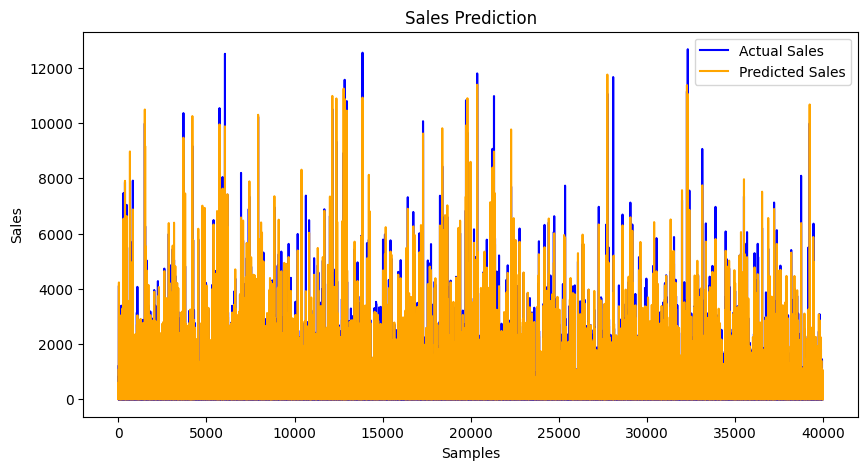

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load your data
# data_set = pd.read_csv('your_data.csv')  # Replace with your data file




# Apply backward fill to 'dcoilwtico' column
data_set['dcoilwtico'] = data_set['dcoilwtico'].bfill()

# Check for remaining missing values
print(data_set.isnull().sum())

# Define categorical and non-categorical columns
categorical_columns = ['family', 'store_nbr']
non_categorical_columns = ['year', 'month', 'day', 'onpromotion', 'dcoilwtico','is_holiday','is_weekend']
target_column = 'sales'

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(data_set[categorical_columns])

# Combine encoded categorical variables with non-categorical variables
X = np.hstack((encoded_cats, data_set[non_categorical_columns].values))
y = data_set[target_column].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize non-categorical columns
scaler = StandardScaler()
X_train[:, -len(non_categorical_columns):] = scaler.fit_transform(X_train[:, -len(non_categorical_columns):])
X_test[:, -len(non_categorical_columns):] = scaler.transform(X_test[:, -len(non_categorical_columns):])

# Define the DNN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can visualize the predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Sales', color='blue')
plt.plot(predictions, label='Predicted Sales', color='orange')
plt.legend()
plt.title('Sales Prediction')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.show()


added additional features

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
is_holiday      0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
day             0
day_of_week     0
month           0
year            0
is_weekend      0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          27,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,225 (141.50 KB)

 Trainable params: 36,225 (141.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 276431.5312 - val_loss: 46771.8438
Epoch 2/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 48259.6406 - val_loss: 34085.6758
Epoch 3/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 48234.7188 - val_loss: 27455.5879
Epoch 4/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 33665.2266 - val_loss: 25609.6875
Epoch 5/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 28972.8633 - val_loss: 22800.0234
Epoch 6/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 33805.0117 - val_loss: 21001.9297
Epoch 7/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 31695.2871 - val_loss: 20370.2148
Epoch 8/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 30499.7031 - val_loss: 23568.2383
Epoch 9/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 24893.9824 - val_loss: 18684.1816
Epoch 10/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 26574.9590 - val_loss: 19343.2422
Epoch 11/50
4000/4000 ━━━━━━━━━━━

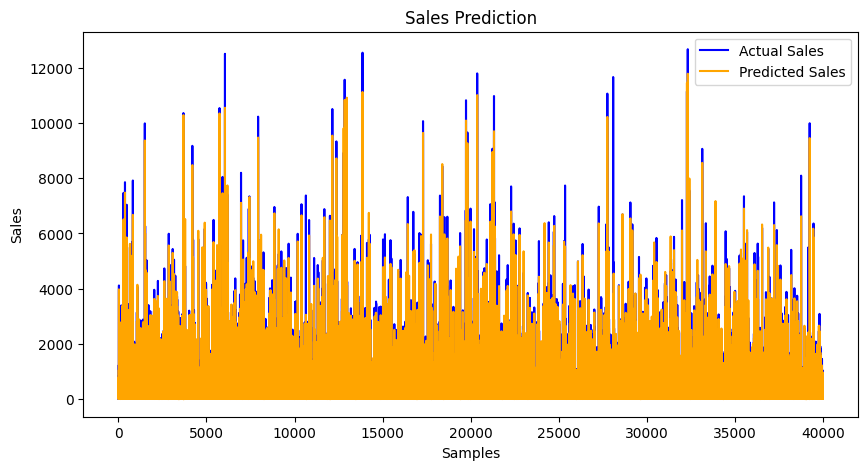

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load your data
# data_set = pd.read_csv('your_data.csv')  # Replace with your data file




# Apply backward fill to 'dcoilwtico' column
data_set['dcoilwtico'] = data_set['dcoilwtico'].bfill()

# Check for remaining missing values
print(data_set.isnull().sum())


categorical_columns = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster', 'locale', 'locale_name', 'description', 'holiday_type', 'day_of_week', 'month', 'day']
non_categorical_columns = ['year', 'is_holiday', 'onpromotion', 'dcoilwtico']
target_column = 'sales'


# Define categorical and non-categorical columns
#categorical_columns = ['family', 'store_nbr']
#non_categorical_columns = ['year', 'month', 'day', 'onpromotion', 'dcoilwtico','is_holiday','is_weekend']
#target_column = 'sales'

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(data_set[categorical_columns])

# Combine encoded categorical variables with non-categorical variables
X = np.hstack((encoded_cats, data_set[non_categorical_columns].values))
y = data_set[target_column].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize non-categorical columns
scaler = StandardScaler()
X_train[:, -len(non_categorical_columns):] = scaler.fit_transform(X_train[:, -len(non_categorical_columns):])
X_test[:, -len(non_categorical_columns):] = scaler.transform(X_test[:, -len(non_categorical_columns):])

# Define the DNN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can visualize the predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Sales', color='blue')
plt.plot(predictions, label='Predicted Sales', color='orange')
plt.legend()
plt.title('Sales Prediction')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.show()


further fine tuning

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 199294.6562 - val_loss: 33959.1719 - learning_rate: 0.0010
Epoch 2/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 49847.2188 - val_loss: 23889.1211 - learning_rate: 0.0010
Epoch 3/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 35443.5664 - val_loss: 21364.7676 - learning_rate: 0.0010
Epoch 4/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 22050.8184 - val_loss: 18825.9707 - learning_rate: 0.0010
Epoch 5/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 24072.7148 - val_loss: 18890.5879 - learning_rate: 0.0010
Epoch 6/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 21245.1738 - val_loss: 17402.2676 - learning_rate: 0.0010
Epoch 7/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 18065.2090 - val_loss: 21013.5508 - learning_rate: 0.0010
Epoch 8/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 23518.5723 - val_loss: 18004.4824 - learning_rate: 0.0010
Epoch 9/50
4000/4000 ━━━━━━━━━━

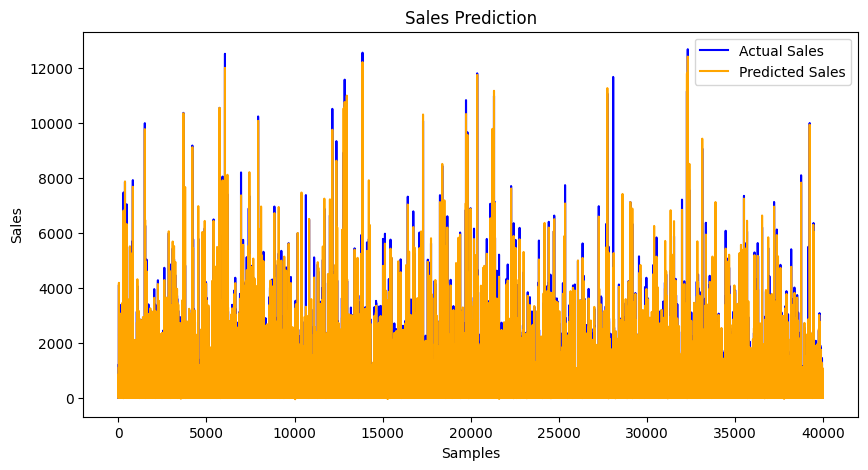

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Load your dataset

# Specify your columns
categorical_columns = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster', 'locale',
                       'locale_name', 'description', 'holiday_type', 'day_of_week', 'month', 'day']
non_categorical_columns = ['year', 'is_holiday', 'onpromotion', 'dcoilwtico','is_weekend']
target_column = 'sales'

# Separate features and target
features = data_set[categorical_columns + non_categorical_columns]
target = data_set[target_column]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(features[categorical_columns])

# Standardize numerical features
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(features[non_categorical_columns])

# Combine processed features
processed_features = np.hstack([encoded_cats, scaled_nums])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(processed_features, target, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(predictions.flatten(), label='Predicted Sales', color='orange')
plt.legend()
plt.title('Sales Prediction')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.show()




In [ ]:
results_df = pd.DataFrame({
    'Actual Sales': y_test,
    'Predicted Sales': predictions.flatten()  # Flatten the predictions array if necessary
})

# Print the DataFrame
print(results_df)

        Actual Sales  Predicted Sales
119737        12.000         6.207090
72272          2.000        -0.934755
158154         0.000        -0.846132
65426          8.000         2.169737
30074          0.000        -0.121645
...              ...              ...
4174           0.000        -0.674135
91537        180.370       174.091187
156449       232.143       134.032104
184376       130.000        99.785065
6584           0.000        -1.036928

[40000 rows x 2 columns]


date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
is_holiday      0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
day             0
day_of_week     0
month           0
year            0
is_weekend      0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14179/14179 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 114770.1406 - val_loss: 25470.2461 - learning_rate: 0.0010
Epoch 2/50
14179/14179 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 31994.2422 - val_loss: 21085.3164 - learning_rate: 0.0010
Epoch 3/50
14179/14179 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 26473.6641 - val_loss: 20222.7051 - learning_rate: 0.0010
Epoch 4/50
14179/14179 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 24399.4258 - val_loss: 20825.1113 - learning_rate: 0.0010
Epoch 5/50
14179/14179 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 24964.7695 - val_loss: 21071.5195 - learning_rate: 0.0010
Epoch 6/50
14179/14179 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 25841.2168 - val_loss: 19684.0762 - learning_rate: 0.0010
Epoch 7/50
14179/14179 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 20959.2598 - val_loss: 17595.9570 - learning_rate: 0.0010
Epoch 8/50
14179/14179 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 19618.1367 - val_loss: 15959.1240 - learning_rate: 0.0010
Epoch 9/50
1417

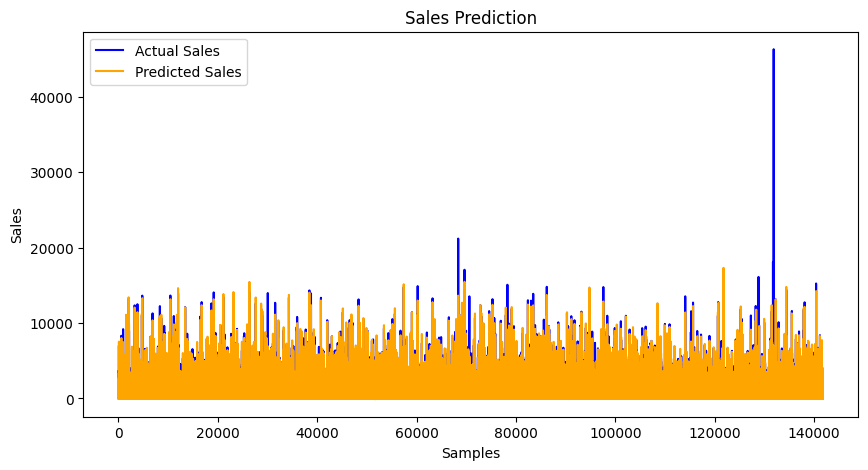

In [ ]:
#Adding more nurons to learn patterns

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Apply backward fill to 'dcoilwtico' column
data_set['dcoilwtico'] = data_set['dcoilwtico'].bfill()


# Check for remaining missing values
print(data_set.isnull().sum())

# Specify your columns
categorical_columns = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster', 'locale',
                       'locale_name', 'description', 'holiday_type', 'day_of_week', 'month', 'day']
non_categorical_columns = ['year', 'is_holiday', 'onpromotion', 'dcoilwtico','is_weekend']
target_column = 'sales'

# Separate features and target
features = data_set[categorical_columns + non_categorical_columns]
target = data_set[target_column]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(features[categorical_columns])

# Standardize numerical features
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(features[non_categorical_columns])

# Combine processed features
processed_features = np.hstack([encoded_cats, scaled_nums])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(processed_features, target, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(predictions.flatten(), label='Predicted Sales', color='orange')
plt.legend()
plt.title('Sales Prediction')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.show()




In [ ]:
results_df = pd.DataFrame({
    'Actual Sales': y_test,
    'Predicted Sales': predictions.flatten()  # Flatten the predictions array if necessary
})

# Print the DataFrame
print(results_df)

        Actual Sales  Predicted Sales
227612       275.038       286.059204
654632       501.999       417.094025
657060        55.000        50.676132
295382        27.277        51.718399
391142         0.000        -2.207900
...              ...              ...
241637        27.595        51.885223
409796         4.000         4.445909
51360       2156.000      2494.810547
592221       274.000       415.002136
411710         5.000         1.603105

[141782 rows x 2 columns]


Add more layers

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
is_holiday      0
dcoilwtico      0
city            0
state           0
type            0
cluster         0
day             0
day_of_week     0
month           0
year            0
is_weekend      0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3545/3545 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 179150.8438 - val_loss: 33178.3516 - learning_rate: 0.0010
Epoch 2/50
3545/3545 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 38682.0312 - val_loss: 25076.3926 - learning_rate: 0.0010
Epoch 3/50
3545/3545 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 29371.8965 - val_loss: 22793.6641 - learning_rate: 0.0010
Epoch 4/50
3545/3545 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 29148.2773 - val_loss: 17681.3574 - learning_rate: 0.0010
Epoch 5/50
3545/3545 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 23762.6855 - val_loss: 18769.5312 - learning_rate: 0.0010
Epoch 6/50
3545/3545 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 24120.5352 - val_loss: 18345.2480 - learning_rate: 0.0010
Epoch 7/50
3545/3545 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 23380.4316 - val_loss: 16840.8887 - learning_rate: 0.0010
Epoch 8/50
3545/3545 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 22965.0469 - val_loss: 17411.6973 - learning_rate: 0.0010
Epoch 9/50
3545/3545 ━━━━━━━━━━━━

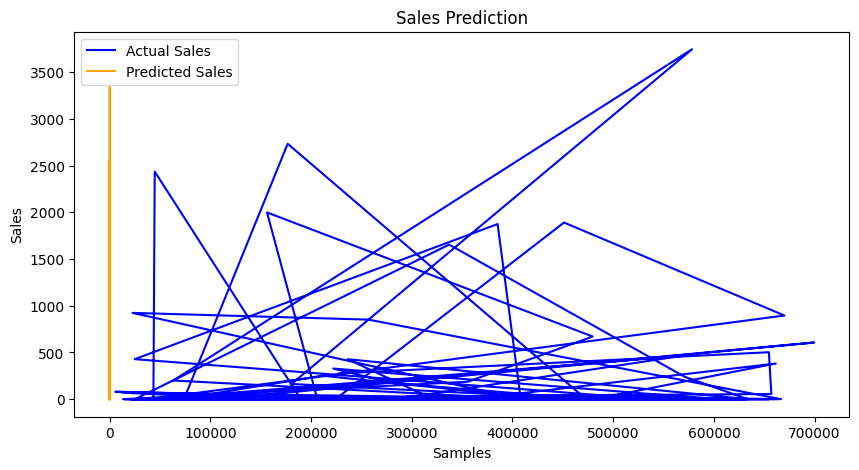

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

# For reproducibility
np.random.seed(42)

# Apply backward fill to 'dcoilwtico' column
data_set['dcoilwtico'] = data_set['dcoilwtico'].bfill()

# Check for remaining missing values
print(data_set.isnull().sum())

# Specify your columns
categorical_columns = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster', 'locale',
                       'locale_name', 'description', 'holiday_type', 'day_of_week', 'month', 'day']
non_categorical_columns = ['year', 'is_holiday', 'onpromotion', 'dcoilwtico', 'is_weekend']
target_column = 'sales'

# Separate features and target
features = data_set[categorical_columns + non_categorical_columns]
target = data_set[target_column]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(features[categorical_columns])

# Standardize numerical features
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(features[non_categorical_columns])

# Combine processed features
processed_features = np.hstack([encoded_cats, scaled_nums])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(processed_features, target, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'))
model.add(Dense(1))  # Output layer

# Compile the model with SGD optimizer
optimizer = SGD(learning_rate=0.0001, momentum=0.9, clipvalue=1.0)
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# Print actual vs predicted values
for actual, predicted in zip(y_test[:10], predictions[:10]):  # Display the first 10 for brevity
    print(f'Actual: {actual}, Predicted: {predicted[0]}')

# Optionally, visualize the predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label='Actual Sales', color='blue')  # Plotting first 100 values for clarity
plt.plot(predictions[:100], label='Predicted Sales', color='orange')
plt.legend()
plt.title('Sales Prediction')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.show()


4431/4431 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


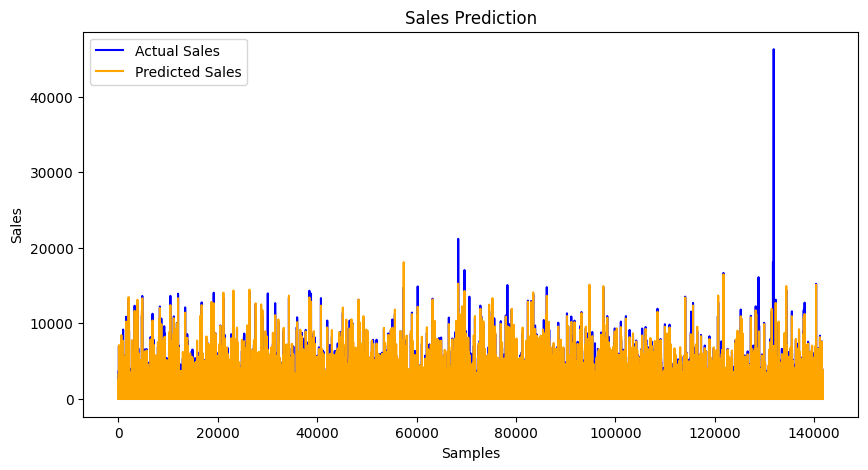

        Actual Sales  Predicted Sales
227612       275.038       216.133957
654632       501.999       618.610779
657060        55.000        31.890871
295382        27.277        28.434998
391142         0.000         0.123150
...              ...              ...
241637        27.595        30.420288
409796         4.000         0.243058
51360       2156.000      2222.862549
592221       274.000       371.271637
411710         5.000         0.256327

[141782 rows x 2 columns]


In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Optionally, you can visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(predictions.flatten(), label='Predicted Sales', color='orange')
plt.legend()
plt.title('Sales Prediction')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.show()


results_df = pd.DataFrame({
    'Actual Sales': y_test,
    'Predicted Sales': predictions.flatten()  # Flatten the predictions array if necessary
})

# Print the DataFrame
print(results_df)